In [1]:
import pandas as pd
import requests
import os
import io
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path_download_zip_data = 'https://archive.ics.uci.edu/static/public/851/steel+industry+energy+consumption.zip'
path_raw_download = r"../data/0_raw"

In [3]:
response = requests.get(path_download_zip_data)

In [4]:
if response.status_code == 200:
    zip_file = io.BytesIO(response.content)

    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(path_raw_download)

In [5]:
data = pd.read_csv(os.path.join(path_raw_download, 'Steel_industry_data.csv'))
print(data.shape)
data.head()

(35040, 11)


,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load


In [6]:
data.dtypes

date                                     object
Usage_kWh                               float64
Lagging_Current_Reactive.Power_kVarh    float64
Leading_Current_Reactive_Power_kVarh    float64
CO2(tCO2)                               float64
Lagging_Current_Power_Factor            float64
Leading_Current_Power_Factor            float64
NSM                                       int64
WeekStatus                               object
Day_of_week                              object
Load_Type                                object
dtype: object

In [7]:
dict(data.dtypes).values()

dict_values([dtype('O'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('int64'), dtype('O'), dtype('O'), dtype('O')])

In [8]:
data_types = {'date',
              'Usage_kWh',
              'Lagging_Current_Reactive.Power_kVarh',
              'Leading_Current_Reactive_Power_kVarh',
              'CO2(tCO2)',
              'Lagging_Current_Power_Factor',
              'Leading_Current_Power_Factor',
              'NSM',
              'WeekStatus',
              'Day_of_week',
              'Load_Type',
              'hours',
              'week_day_coded',
              'day_week_encoder',
              'loadtype_encoder'
            }

In [9]:
data.isna().sum()

date                                    0
Usage_kWh                               0
Lagging_Current_Reactive.Power_kVarh    0
Leading_Current_Reactive_Power_kVarh    0
CO2(tCO2)                               0
Lagging_Current_Power_Factor            0
Leading_Current_Power_Factor            0
NSM                                     0
WeekStatus                              0
Day_of_week                             0
Load_Type                               0
dtype: int64

In [10]:
data.WeekStatus.unique()

array(['Weekday', 'Weekend'], dtype=object)

In [11]:
data.Day_of_week.unique()

array(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
       'Sunday'], dtype=object)

In [12]:
data.Load_Type.unique()

array(['Light_Load', 'Medium_Load', 'Maximum_Load'], dtype=object)

# Feature Engineering

Primero vamos a asignar los valores categoricos a una variable numérica debido a su baja dimensionalidad y además asignar un orden a las categorias

In [13]:
week_day_encoder = {'Weekday': 0,
                    'Weekend': 1}
day_week_encoder = {'Monday': 0,
                    'Tuesday': 1,
                    'Wednesday': 2,
                    'Thursday': 3,
                    'Friday': 4,
                    'Saturday': 5,
                    'Sunday': 6}
load_type_encoder = {'Light_Load': 0 ,
                     'Medium_Load': 1,
                     'Maximum_Load': 2}

In [14]:
data['week_day_coded'] = data.WeekStatus.map(week_day_encoder)
data['day_week_encoder'] = data.Day_of_week.map(day_week_encoder)
data['loadtype_encoder'] = data.Load_Type.map(load_type_encoder)

Asignamos los formatos correctos de fechas

In [15]:
data.date = pd.to_datetime(data.date, format="%d/%m/%Y %H:%M")

In [16]:
data['hours'] = data['date'].dt.hour

# Visualizaciones

<Axes: xlabel='date', ylabel='Usage_kWh'>

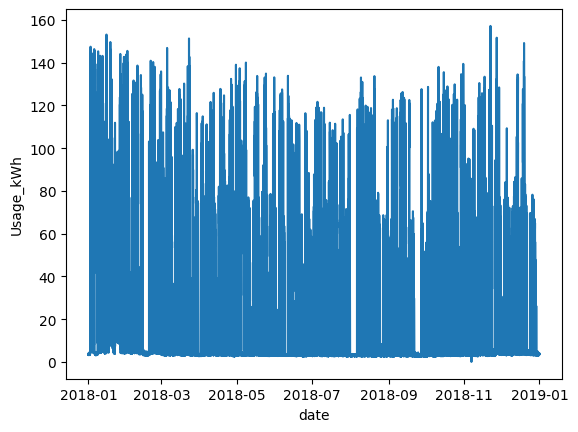

In [17]:
sns.lineplot(data=data,
             x='date',
             y='Usage_kWh')

<Axes: xlabel='date', ylabel='Usage_kWh'>

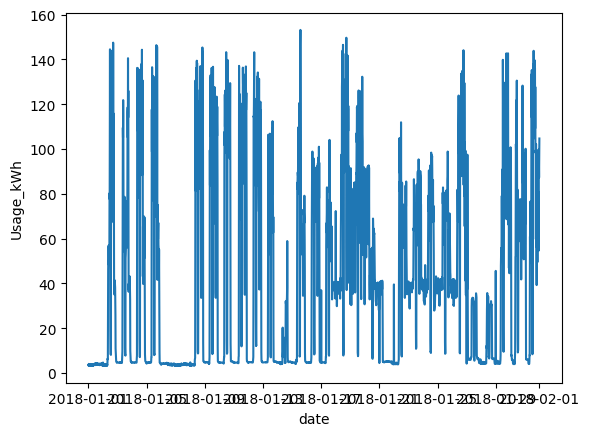

In [18]:
sns.lineplot(data=data.loc[(data.date >= '2018-01-01') &
                           (data.date <= '2018-02-01')],
             x='date',
             y='Usage_kWh')

<Axes: xlabel='date', ylabel='Usage_kWh'>

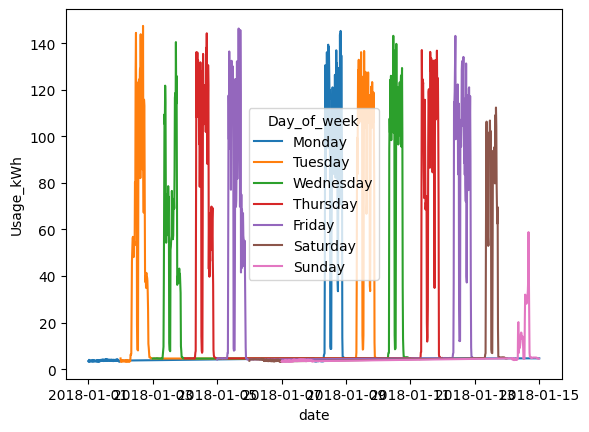

In [19]:
sns.lineplot(data=data.loc[(data.date >= '2018-01-01') &
                           (data.date <= '2018-01-15')],
             x='date',
             y='Usage_kWh',
             hue='Day_of_week')

<Axes: xlabel='Load_Type', ylabel='Usage_kWh'>

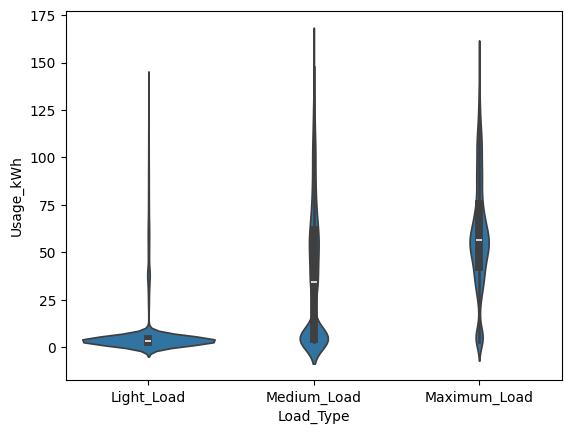

In [20]:
sns.violinplot(data=data,
            x='Load_Type',
            y='Usage_kWh')

<Axes: xlabel='hours', ylabel='Usage_kWh'>

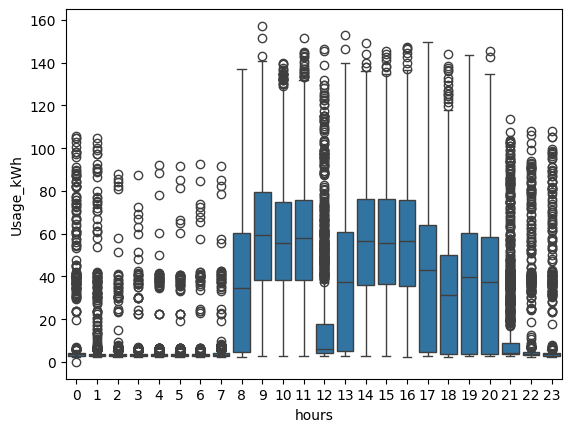

In [21]:
sns.boxplot(data=data,
            x='hours',
            y='Usage_kWh')

Podemos ver que hay cierta relación entre las horas de usos más altos y los picos de uso más pesados de usos de voltaje

# Data Separation

In [22]:
X_cols = [
        'Leading_Current_Reactive_Power_kVarh',
        'CO2(tCO2)',
        'Lagging_Current_Power_Factor',
        'Leading_Current_Power_Factor',
        'NSM',
        'Load_Type',
        'hours',
        'week_day_coded',
        'day_week_encoder',
        'loadtype_encoder']
y_cols = 'Usage_kWh'

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
X = data[X_cols]
y = data[y_cols]

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [26]:
from pycaret.regression import *

In [27]:
s = RegressionExperiment()
s.setup(data, target=y_cols)

,Description,Value
0,Session id,1793
1,Target,Usage_kWh
2,Target type,Regression
3,Original data shape,"(35040, 15)"
4,Transformed data shape,"(35040, 25)"
5,Transformed train set shape,"(24528, 25)"
6,Transformed test set shape,"(10512, 25)"
7,Numeric features,10
8,Date features,1
9,Categorical features,3


In [28]:
best = s.compare_models()
best

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.3928,1.2808,1.1236,0.9988,0.0341,0.0145,8.0270
et,Extra Trees Regressor,0.4734,1.4639,1.2069,0.9987,0.0321,0.0163,7.1850
dt,Decision Tree Regressor,0.6137,2.5992,1.6037,0.9977,0.0471,0.0223,0.8750
lightgbm,Light Gradient Boosting Machine,0.8372,2.7035,1.6348,0.9976,0.0760,0.0605,81.4080
gbr,Gradient Boosting Regressor,1.7389,8.5799,2.9272,0.9923,0.1194,0.0993,5.3950
lr,Linear Regression,2.6411,22.8530,4.7542,0.9795,0.2268,0.1925,8.7230
br,Bayesian Ridge,2.6415,22.8530,4.7543,0.9795,0.2270,0.1926,0.5450
ada,AdaBoost Regressor,5.0387,30.9787,5.5611,0.9722,0.6127,0.9611,3.7470
knn,K Neighbors Regressor,3.0585,40.4748,6.3595,0.9637,0.1483,0.1132,1.8290
ridge,Ridge Regression,5.0937,50.9082,7.1327,0.9544,0.5063,0.6282,0.5120


RandomForestRegressor(n_jobs=-1, random_state=1793)

In [29]:
s.evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

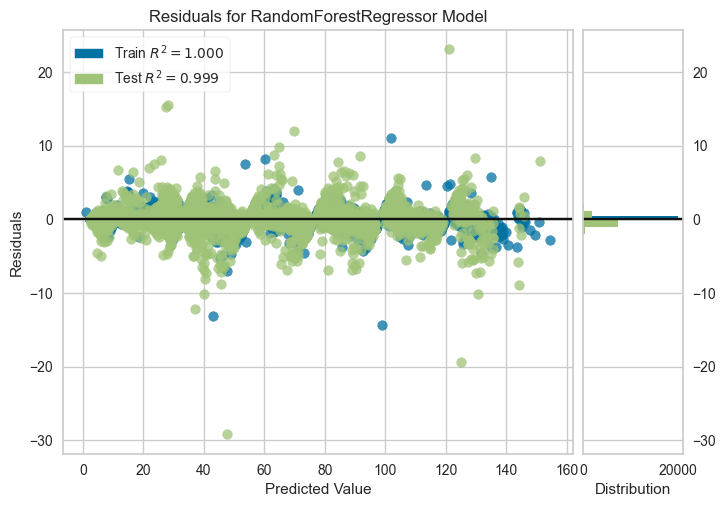

In [30]:
s.plot_model(best, plot='residuals')

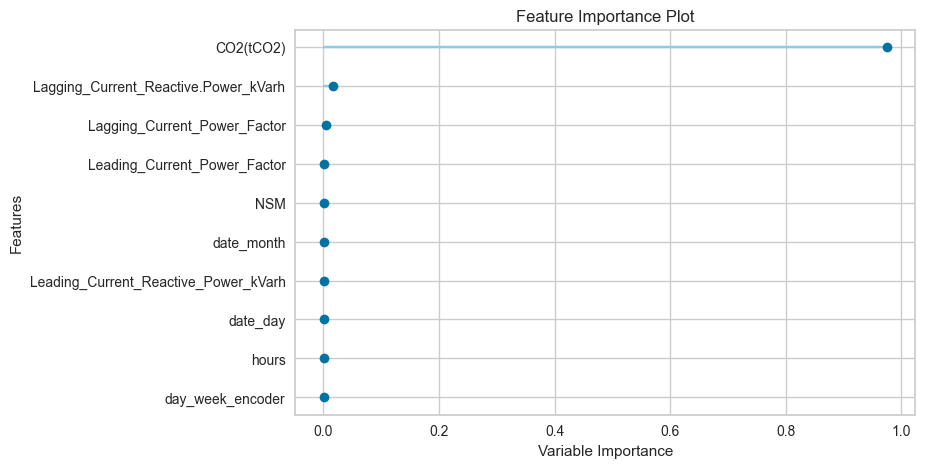

In [31]:

s.plot_model(best, plot = 'feature')

In [32]:

s.predict_model(best)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.3861,1.1136,1.0553,0.9990,0.0327,0.0142


,date,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type,week_day_coded,day_week_encoder,loadtype_encoder,hours,Usage_kWh,prediction_label
5938,2018-03-03 20:45:00,0.000000,17.959999,0.00,100.000000,17.379999,74700,Weekend,Saturday,Medium_Load,1,5,1,20,3.170000,3.176300
18380,2018-07-11 11:15:00,43.090000,0.000000,0.03,81.589996,100.000000,40500,Weekday,Wednesday,Maximum_Load,0,2,2,11,60.799999,60.669200
24522,2018-09-13 10:45:00,29.299999,0.000000,0.02,87.040001,100.000000,38700,Weekday,Thursday,Maximum_Load,0,3,2,10,51.799999,51.819100
6584,2018-03-10 14:15:00,0.070000,9.320000,0.01,100.000000,95.129997,51300,Weekend,Saturday,Maximum_Load,1,5,2,14,28.760000,29.079100
13623,2018-05-22 22:00:00,0.000000,16.420000,0.00,100.000000,19.760000,79200,Weekday,Tuesday,Medium_Load,0,1,1,22,3.310000,3.318800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25017,2018-09-18 14:30:00,30.170000,0.000000,0.03,88.489998,100.000000,52200,Weekday,Tuesday,Maximum_Load,0,1,2,14,57.310001,57.027999
3608,2018-02-07 14:15:00,19.219999,0.000000,0.03,95.699997,100.000000,51300,Weekday,Wednesday,Medium_Load,0,2,1,14,63.400002,63.756200
25956,2018-09-28 09:15:00,30.240000,0.000000,0.02,87.389999,100.000000,33300,Weekday,Friday,Medium_Load,0,4,1,9,54.360001,53.624900
26101,2018-09-29 21:30:00,0.000000,11.740000,0.00,100.000000,23.280001,77400,Weekend,Saturday,Medium_Load,1,5,1,21,2.810000,2.857000


Como podemos ver el modelo tiene como variable predictora casi única el CO2 pero ahora vamos a ver como es que se comportaría el modelo si es que no tuviera esta columna.

Entrenamiento sin CO2

In [33]:
e = RegressionExperiment()
data_mod = data.drop('CO2(tCO2)', axis=1)
e.setup(data_mod,
        target=y_cols)

,Description,Value
0,Session id,961
1,Target,Usage_kWh
2,Target type,Regression
3,Original data shape,"(35040, 14)"
4,Transformed data shape,"(35040, 24)"
5,Transformed train set shape,"(24528, 24)"
6,Transformed test set shape,"(10512, 24)"
7,Numeric features,9
8,Date features,1
9,Categorical features,3


In [34]:
best = e.compare_models()
best

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.2887,0.8045,0.8949,0.9993,0.0258,0.0118,2.2390
rf,Random Forest Regressor,0.2953,0.9161,0.9505,0.9992,0.0337,0.0122,2.8580
lightgbm,Light Gradient Boosting Machine,0.5585,1.2736,1.1267,0.9989,0.0505,0.0391,0.3410
dt,Decision Tree Regressor,0.6051,2.5724,1.5924,0.9977,0.0497,0.0214,0.1240
gbr,Gradient Boosting Regressor,1.2057,4.7491,2.1752,0.9958,0.1385,0.1096,0.8230
knn,K Neighbors Regressor,3.0055,39.0496,6.2444,0.9652,0.1474,0.1134,0.1840
ada,AdaBoost Regressor,7.3339,67.7238,8.2079,0.9396,0.7355,1.2785,0.6840
ridge,Ridge Regression,6.9474,90.1424,9.4928,0.9196,0.5387,0.8962,0.0720
br,Bayesian Ridge,6.9447,90.1425,9.4928,0.9196,0.5390,0.8954,0.0840
lr,Linear Regression,6.9475,90.1424,9.4928,0.9196,0.5387,0.8962,0.0790


ExtraTreesRegressor(n_jobs=-1, random_state=961)

In [35]:
e.evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

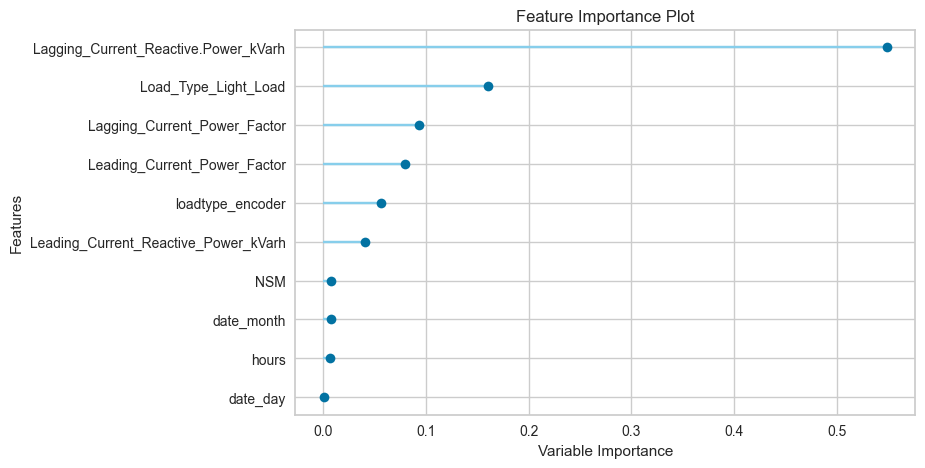

In [36]:
e.plot_model(best, plot='feature')

In [37]:
e.predict_model(best)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.2700,0.6559,0.8099,0.9994,0.0290,0.0112


,date,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type,week_day_coded,day_week_encoder,loadtype_encoder,hours,Usage_kWh,prediction_label
28531,2018-10-25 05:00:00,6.010000,0.00,45.840000,100.000000,18000,Weekday,Thursday,Light_Load,0,3,0,5,3.100000,3.103900
26696,2018-10-06 02:15:00,5.870000,0.00,44.540001,100.000000,8100,Weekend,Saturday,Light_Load,1,5,0,2,2.920000,2.893600
7908,2018-03-24 09:15:00,1.910000,0.72,99.879997,99.980003,33300,Weekend,Saturday,Medium_Load,1,5,1,9,38.740002,39.037100
18424,2018-07-11 22:15:00,0.900000,12.06,97.080002,28.889999,80100,Weekday,Wednesday,Medium_Load,0,2,1,22,3.640000,3.654500
3067,2018-02-01 23:00:00,56.700001,0.00,88.059998,100.000000,82800,Weekday,Thursday,Maximum_Load,0,3,2,23,105.370003,103.250599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27384,2018-10-13 06:15:00,5.980000,0.00,48.430000,100.000000,22500,Weekend,Saturday,Light_Load,1,5,0,6,3.310000,3.318000
17777,2018-07-05 04:30:00,4.970000,0.00,51.930000,100.000000,16200,Weekday,Thursday,Light_Load,0,3,0,4,3.020000,3.021200
26220,2018-10-01 03:15:00,5.110000,0.00,45.209999,100.000000,11700,Weekday,Monday,Light_Load,0,0,0,3,2.590000,2.608800
30863,2018-11-18 12:00:00,8.350000,2.81,97.199997,99.669998,43200,Weekend,Sunday,Maximum_Load,1,6,2,12,34.520000,34.566400


Ahora tenemos ya una mejor distribución del poder de preditivilidad de nuestro modelo además de tener un mayor score de MAE: Mean Absolute Error.